# GCN link prediction using the karate-club graph

kGCN: https://github.com/clinfo/kGCN

This sample code demonstrates how to use kGCN (python module) for a toy link prediction problem.  

## Installation of kGCN

kGCN is available from git using the following pip command: 

In [1]:
! pip install git+https://github.com/clinfo/kGCN.git


  Cloning https://github.com/clinfo/kGCN.git to /tmp/pip-req-build-c4hm24l_
  Running command git clone -q https://github.com/clinfo/kGCN.git /tmp/pip-req-build-c4hm24l_
  Created wheel for kGCN: filename=kGCN-1.0-cp36-none-any.whl size=45979 sha256=f5c6c083386a74814a88d4383b8a9b1baeafe21c2eae7777558a37c377b0c6f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-b3n4gxsj/wheels/05/46/ea/77d5fa3130104696b6ad4d696d46726da54b3f472d227bf587
Successfully built kGCN


## Preparation of the dataset

### constructing graph

This sample code uses a standard graph library *networkX* and karate-club graph, a small benchmark graph.

#nodes:  34
#edges:  78


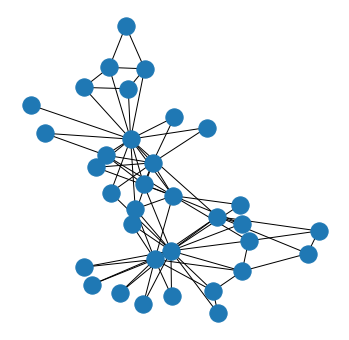

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

G = nx.karate_club_graph()
print("#nodes: ",nx.number_of_nodes(G))
print("#edges: ",nx.number_of_edges(G))

# Visualization
pos = nx.spring_layout(G)
plt.figure(figsize=(6, 6))
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos)
plt.axis('off')
plt.show()

### Constructing a dataset by converting the networkX graph

To use graph convolutional network, the adjacency matrix and labels, i.e., the prediction target is link in this case, should be computed from the graph.

In [0]:
# adjacency matrix (sparse format)
node_num=nx.number_of_nodes(G)
adj_idx=np.array(G.edges())
adj_val=np.ones((nx.number_of_edges(G),))
adj_shape=[node_num,node_num]
adjs=[(adj_idx,adj_val,adj_shape)]

# node list
node_ids=[G.nodes()]

# generating labels(edge) at random
# In kGCN, an edge is represented as a triple (node1, edge type, node2)
# In this case, edge type is dummy 0. 
label_list=[]
for _ in range(10):
    x1=np.random.randint(node_num)
    x2=np.random.randint(node_num)
    x3=np.random.randint(node_num)
    ## positive edge between x1 and x2 with dummy type 0
    pos_label=[x1,0,x2]
    ## negative edge between x1 and x3 with dummy type 0
    neg_label=[x1,0,x3]
    label_list.append(pos_label+neg_label)
label_list=np.array([label_list])

# This dictionary is used as an input of kGCN
obj={
    "adj":[adjs],
    "node":node_ids,
    "node_num":node_num,
    "label_list":label_list,
    "max_node_num":node_num}

## Defining a neural network with graph convolution

kGCN provides kgcn.layers module to construct graph convolutional networks.
GraphConv represents a convolution operation.
Operators in this module are compatible with Keras library, which  provides a high-level interface on Tensorflow.

In kGCN, users should define one neural network class (NNModel) with two methods: build_placeholders and build_model.


In [0]:
import kgcn.layers
from kgcn.default_model import DefaultModel
import tensorflow.contrib.keras as K

class NNModel(DefaultModel):
    def build_placeholders(self,info,config,batch_size):
        # input data types (placeholders) of this neural network
        return self.get_placeholders(info,config,batch_size,
            ["adjs","nodes","preference_label_list"])

    def build_model(self,placeholders,info,config,batch_size):
        # input data and parameters of this neural network
        adj_channel_num=info.adj_channel_num
        embedding_dim=config["embedding_dim"]
        in_adjs=placeholders["adjs"]
        in_nodes=placeholders["nodes"]
        label_list=placeholders["preference_label_list"]

        # constructing neural network
        layer=K.layers.Embedding(info.all_node_num,embedding_dim)(in_nodes)
        layer=kgcn.layers.GraphConv(64,adj_channel_num)(layer,adj=in_adjs)
        layer=tf.nn.sigmoid(layer)
        lp_prediction=tf.matmul(layer,layer,transpose_b=True)
        
        # extracting vectors associated with edges in the label list
        pred0=tf.gather(prediction[0,:,:],label_list[0,:,0])
        pred1=tf.gather(prediction[0,:,:],label_list[0,:,2])
        pred2=tf.gather(prediction[0,:,:],label_list[0,:,3])
        pred3=tf.gather(prediction[0,:,:],label_list[0,:,5])

        # computing preference loss function
        s1=tf.reduce_sum(pred0*pred1,axis=1)
        s2=tf.reduce_sum(pred2*pred3,axis=1)
        output=1.0/(1.0+tf.exp(s2-s1))

        # computing cost function for optimization
        cost=-1*tf.log(output+1.0e-10)
        cost_opt=tf.reduce_mean(cost)
        metrics={}
        cost_sum=tf.reduce_sum(cost)
        
        # computing metrics (like accuracy) for evaluation 
        pre_count=tf.cast(tf.greater(s1,s2),tf.float32)
        metrics["correct_count"]=tf.reduce_sum(pre_count)
        count=tf.shape(label_list[0,:,0])[0]
        metrics["count"]=count

        return layer,lp_prediction,cost_opt,cost_sum,metrics
        
      

## Loading the dataset using utilities in kGCN 

kGCN provides preprocessing for graph convolution.
Users can specify configuration as an argument.
Please see kGCN github page (https://github.com/clinfo/kGCN) for this configuration. 


In [6]:
import kgcn
import kgcn.data_util
import kgcn.core
import tensorflow as tf

config={
    "with_node_embedding":True,
    "normalize_adj_flag":True,
    "split_adj_flag":False,
    "shuffle_data":False,
}
train_data, info = kgcn.data_util.build_data(config, obj)


[OK] checking #graphs
The number of graphs                   = 1
Dimension of a feature                 = 0
The maximum number of nodes in a graph = 34
The number of nodes in all graphs      = 34
Dimension of a label                   = None
The number of adj. matrices in a graph = 1


## Launching Tensorflow session to construct an actual model by instantiating NNModel



In [8]:
sess=tf.Session()
config={
    "batch_size":100,
    "embedding_dim":10,
    "learning_rate":0.01,
    "param":None,
    "retrain":None,
    "save_model_path":"model",
    "epoch":5,
    "profile":None,
    "task":"classification",
    "save_interval":2,
    }

model = kgcn.core.CoreModel(sess,config,info)
nn=NNModel()
model.build(nn)


W0903 12:36:33.704861 139828412020608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/kgcn/default_model.py:7: The name tf.sparse_placeholder is deprecated. Please use tf.compat.v1.sparse_placeholder instead.

W0903 12:36:33.888497 139828412020608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/kgcn/default_model.py:8: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 12:36:33.897526 139828412020608 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0903 12:36:33.920960 139828412020608 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: call

Tensor("mul_2:0", shape=(?,), dtype=float32)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Training the neural network

Let's start trainig.
Like many machine learning libraries, kGCN also starts parameter training by one line.  

In [9]:
model.fit(train_data)


W0903 12:36:51.775463 139828412020608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/kgcn/core.py:217: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



#train data =  1
epoch 0, training cost 6.92703 (acc=0.3), validation cost 0 (acc=0) (count=0) ([SAVE] model/model.00000.ckpt) 
[SAVE]  model/model.best.ckpt
epoch 1, training cost 7.4293 (acc=0.1), validation cost 0 (acc=0) (count=0) 
epoch 2, training cost 6.71725 (acc=0.3), validation cost 0 (acc=0) (count=0) ([SAVE] model/model.00002.ckpt) 
epoch 3, training cost 6.98678 (acc=0.5), validation cost 0 (acc=0) (count=0) 


W0903 12:36:56.445040 139828412020608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


epoch 4, training cost 6.76847 (acc=0.4), validation cost 0 (acc=0) (count=0) ([SAVE] model/model.00004.ckpt) 
[RESTORE]  model/model.best.ckpt
[SAVE]  model/model.last.ckpt


## Prediction

In the link predition, the prediction result is a sore matrix (#nodes x #nodes).
The higher this score, the more likely the new edge in this graph.


In [10]:
train_y=model.pred(train_data)
print(train_y)


[array([[18.24834 , 17.577501, 17.406668, ..., 17.098225, 17.083153,
        17.079071],
       [17.577501, 16.941578, 16.776772, ..., 16.479893, 16.465109,
        16.461014],
       [17.406668, 16.776772, 16.616945, ..., 16.323189, 16.30858 ,
        16.304493],
       ...,
       [17.098225, 16.479893, 16.32319 , ..., 16.03658 , 16.02224 ,
        16.018253],
       [17.083153, 16.465113, 16.308578, ..., 16.02224 , 16.007948,
        16.003973],
       [17.079071, 16.461012, 16.304491, ..., 16.01825 , 16.003973,
        16.      ]], dtype=float32)]
